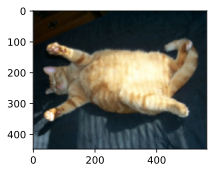

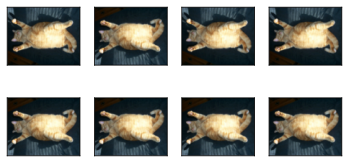

In [1]:
%matplotlib inline
import torch
import torchvision
from torchvision import transforms
from torch import nn
from d2l import torch as d2l
from PIL import Image


# 1.常见的图像增强
d2l.set_figsize()
img = Image.open('../data/cat1.png')
d2l.plt.imshow(img);

def apply(img, aug, num_rows=2, num_cols=4, scale=1.5):
    Y = [aug(img) for _ in range(num_rows * num_cols)]
    d2l.show_images(Y, num_rows, num_cols, scale=scale)


apply(img, torchvision.transforms.RandomVerticalFlip())


